# Project desription

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

Kaggle competition URL: https://www.kaggle.com/c/home-credit-default-risk/overview

# Requirements

- Data exploration
- Feature engineering
- At least several different models built and compared to each other on the validation set and on the public and private leaderboards
- Clean code
- At least median private leaderboard score

# Evaluation criteria

- Private leaderboard score
- How simple is the model
- How fast is the model prediction
- Code quality

***

# Imports

In [1]:
from collections import Counter

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.float_format","{:,.2f}".format)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
import seaborn as sns; sns.set_theme()
import statsmodels.stats.proportion as prop
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib.ticker import FuncFormatter
from scipy.stats import mode
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import HalvingGridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

from custom_transformers import (blend_organization_type, credit_card_dpd, flag_insurance, pos_cash_dpd, pandas_binning, bureau_credit_type_counter, 
                                 prev_credit_type_counter, prev_flag_insurance, annuity_income_ratio, prev_annuity_income_ratio, enquiries,
                                 prev_dpd_flag, down_payment_rate, installments_version, debt_income_ratio, client_social_circle, drop_id,
                                 region_rating, external_source)
from functions import distinct_values, missing_values, export_predictions

C:\Users\gedim\miniconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\gedim\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


***

In [2]:
private_leaderboard = pd.read_csv("data/private_leaderboard.csv")
print("Median private leaderboard score:", private_leaderboard["Score"].median())
print("Highest private leaderboard score:", private_leaderboard["Score"].max())

Median private leaderboard score: 0.78589
Highest private leaderboard score: 0.8057


# Data description

In [3]:
application_train = pd.read_csv("data/application_train.csv")
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0

- Static data for all applications. One row represents one loan in our data sample.

In [4]:
print("Number of samples:", len(application_train))

Number of samples: 307511


In [5]:
application_test = pd.read_csv("data/application_test.csv")

***

In [6]:
bureau = pd.read_csv("data/bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [7]:
print("Number of samples:", len(bureau))

Number of samples: 1716428


***

In [8]:
bureau_balance = pd.read_csv("data/bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [9]:
print("Number of samples:", len(bureau_balance))

Number of samples: 27299925


***

In [10]:
pos_cash_balance = pd.read_csv("data/pos_cash_balance.csv")
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [11]:
print("Number of samples:", len(pos_cash_balance))

Number of samples: 10001358


***

In [12]:
credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.33","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.56",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.56","64,875.56",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.42","31,460.08","31,460.08",0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,"236,572.11",225000,"2,250.00","2,250.00",0.00,0.00,"11,795.76","11,925.00","11,925.00","224,949.29","233,048.97","233,048.97",1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,"453,919.46",450000,0.00,"11,547.00",0.00,"11,547.00","22,924.89","27,000.00","27,000.00","443,044.40","453,919.46","453,919.46",0.00,1,0.00,1.00,101.00,Active,0,0


- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [13]:
print("Number of samples:", len(credit_card_balance))

Number of samples: 3840312


***

In [14]:
previous_application = pd.read_csv("data/previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,2523466,122040,Cash loans,"15,060.74","112,500.00","136,444.50",NaN,"112,500.00",TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,2819243,176158,Cash loans,"47,041.33","450,000.00","470,790.00",NaN,"450,000.00",MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,"31,924.40","337,500.00","404,055.00",NaN,"337,500.00",THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

In [15]:
print("Number of samples:", len(previous_application))

Number of samples: 1670214


***

In [16]:
installments_payments = pd.read_csv("data/installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.59"


- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [17]:
print("Number of samples:", len(installments_payments))

Number of samples: 13605401


***

# Missing values

Before starting data exploration or feature engineering we must deal with the missing values of our datasets. 67 out of 122 features of initial train dataset have missing values, so we must find the best approch how to fill them.

In [18]:
print("Features with missing values:", len(missing_values(application_train)))

Features with missing values: 67


## OWN_CAR_AGE column

Let's start from OWN_CAR_AGE column, where the number of NaN is almost equal to number of samples with N value in FLAG_OWN_CAR column. So according to that I have changed NaN value to 0 if client doesn't have a car. A few empty values left but I'll deal with them later.

In [19]:
missing_values(application_train)[missing_values(application_train)["Feature"] == "OWN_CAR_AGE"]

,Feature,NaN values,"NaN values, %"
21,OWN_CAR_AGE,202929,65.99


In [20]:
print("Clients who doesn't have a car:", len(application_train[application_train["FLAG_OWN_CAR"] == "N"]))

Clients who doesn't have a car: 202924


In [21]:
application_train.loc[application_train["FLAG_OWN_CAR"] == "N", "OWN_CAR_AGE"] = 0
application_test.loc[application_test["FLAG_OWN_CAR"] == "N", "OWN_CAR_AGE"] = 0

In [22]:
missing_values(application_train)[missing_values(application_train)["Feature"] == "OWN_CAR_AGE"]

,Feature,NaN values,"NaN values, %"
21,OWN_CAR_AGE,5,0.00


## Building information

Features with data about buildings where clients live have missing values in more than a half samples. I have decided to drop those columns because it is nearly impossible to try to guess the correct values from given data.

In [23]:
columns_description = pd.read_csv("data/columns_description.csv")
building_info = columns_description[44:91]["Row"].to_list()

missing_values(application_train)[missing_values(application_train)["Feature"].isin(building_info)].head(10)

,Feature,NaN values,"NaN values, %"
62,COMMONAREA_MODE,214865,69.87
48,COMMONAREA_AVG,214865,69.87
76,COMMONAREA_MEDI,214865,69.87
84,NONLIVINGAPARTMENTS_MEDI,213514,69.43
70,NONLIVINGAPARTMENTS_MODE,213514,69.43
56,NONLIVINGAPARTMENTS_AVG,213514,69.43
86,FONDKAPREMONT_MODE,210295,68.39
82,LIVINGAPARTMENTS_MEDI,210199,68.35
54,LIVINGAPARTMENTS_AVG,210199,68.35
68,LIVINGAPARTMENTS_MODE,210199,68.35


In [24]:
application_train = application_train.drop(columns=building_info)
application_test = application_test.drop(columns=building_info)

## External sources

There are three columns with unknown information from external sources. One of them has a little bit more than half of missing values so I'll drop it.

In [25]:
missing_values(application_train)[missing_values(application_train)["Feature"] == "EXT_SOURCE_1"]

,Feature,NaN values,"NaN values, %"
41,EXT_SOURCE_1,173378,56.38


In [26]:
application_train = application_train.drop(columns="EXT_SOURCE_1")
application_test = application_test.drop(columns="EXT_SOURCE_1")

In [27]:
missing_values(application_train)[missing_values(application_train)["Feature"] == "EXT_SOURCE_3"]

,Feature,NaN values,"NaN values, %"
42,EXT_SOURCE_3,60965,19.83


The column EXT_SOURCE_3 has nearly 61 000 missing values and that is almost 20 pct. of all samples. The below frequency graph shows that some values is more frequent than others but the distribution is evenly decreasing and it is not possible to distinguish one value and change with it all NaNs. Instead, I came up with idea to get all distinct values whose number of occurences in the column sums up at least to the half of all samples, and randomly fill missing values with them.

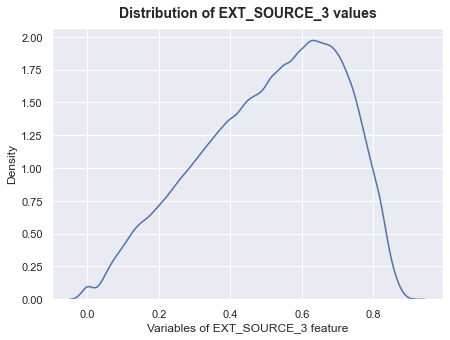

In [28]:
fig, ax = plt.subplots(figsize=(7,5))
sns.kdeplot(ax=ax, data=application_train, x="EXT_SOURCE_3")
plt.title("Distribution of EXT_SOURCE_3 values", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Variables of EXT_SOURCE_3 feature");

In [29]:
application_train = distinct_values(application_train, "EXT_SOURCE_3", 0.5)
application_test = distinct_values(application_test, "EXT_SOURCE_3", 0.5)

## Occupation

Almost one third of all values in OCCUPATION_TYPE is missing and because it's hard to guess which and why, I have decided to state that occupation type is unknown and simply to fill NaN with string Unknown. 

In [30]:
missing_values(application_train)[missing_values(application_train)["Feature"] == "OCCUPATION_TYPE"]

,Feature,NaN values,"NaN values, %"
28,OCCUPATION_TYPE,96391,31.35


In [31]:
application_train["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
application_test["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)

## Number of enquiries to Credit Bureau

All records that are related to enquiries to Credit Bureau about the client have 41 519 missing values. AMT_REQ_CREDIT_BUREAU_YEAR column as EXT_SOURCE_3 doesn't have one distinguishable value so distinct_values function is suitable here. As for the remaining columns, I can fill NaN with most frequent values because these columns have the clear ones. 

In [32]:
missing_values(application_train)[:6]

,Feature,NaN values,"NaN values, %"
73,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.50
72,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.50
71,AMT_REQ_CREDIT_BUREAU_MON,41519,13.50
70,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.50
69,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.50
68,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.50


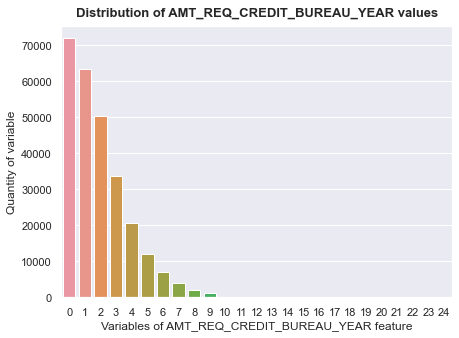

In [33]:
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(ax=ax, data=application_train, x="AMT_REQ_CREDIT_BUREAU_YEAR")
plt.title("Distribution of AMT_REQ_CREDIT_BUREAU_YEAR values", fontsize=13, fontweight="bold", pad=10)
plt.xlabel("Variables of AMT_REQ_CREDIT_BUREAU_YEAR feature")
plt.ylabel("Quantity of variable")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)));

In [34]:
application_train = distinct_values(application_train, "AMT_REQ_CREDIT_BUREAU_YEAR", 0.5)
application_test = distinct_values(application_test, "AMT_REQ_CREDIT_BUREAU_YEAR", 0.5)

In [35]:
amt_req_list = ["AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]
datasets = [application_train, application_test]

for dataset in datasets:
    for feature in amt_req_list:
        dataset[feature].fillna(dataset[feature].mode().iloc[0], inplace=True)

## Remaining columns

After manually inspecting the remaining columns I have decided to fill missing values with mode, even when it is a continuous feature. The amount of left NaNs is a very small fraction of the whole dataset.  

In [36]:
missing_values(application_train)

,Feature,NaN values,"NaN values, %"
11,NAME_TYPE_SUITE,1292,0.42
43,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33
44,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.33
45,OBS_60_CNT_SOCIAL_CIRCLE,1021,0.33
46,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.33
41,EXT_SOURCE_2,660,0.21
10,AMT_GOODS_PRICE,278,0.09
9,AMT_ANNUITY,12,0.00
21,OWN_CAR_AGE,5,0.00
29,CNT_FAM_MEMBERS,2,0.00


In [37]:
remaining_features = missing_values(application_train)["Feature"].to_list()
datasets = [application_train, application_test]

for dataset in datasets:
    for feature in remaining_features:
        dataset[feature].fillna(dataset[feature].mode().iloc[0], inplace=True)

In [38]:
missing_values(application_train)

,Feature,NaN values,"NaN values, %"


In [39]:
missing_values(application_test)

,Feature,NaN values,"NaN values, %"


Both main application train and test datasets are without missing values.

# Base model

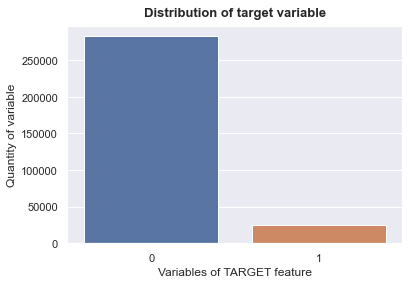

In [40]:
sns.countplot(data=application_train, x="TARGET")
plt.title("Distribution of target variable", fontsize=13, fontweight="bold", pad=10)
plt.xlabel("Variables of TARGET feature")
plt.ylabel("Quantity of variable");

The distribution of target variable is very imbalanced, but I'll deal with this problem later and for the base model will leave it as it is. My base model will be simple Logistic Regression classifier. For the categorical variables encoding I'll use scikit OneHotEncoder in the pipeline.

In [41]:
base_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transformer", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

In [42]:
log_reg = LogisticRegression(random_state=42, max_iter=200)

base_pipeline = Pipeline(
    steps=[
        ("preprocessor", base_preprocessor),
        ("model", log_reg)
    ]
)

In [43]:
# Data used for training and prediction.

X_train = application_train.drop(columns=["SK_ID_CURR", "TARGET"])
y_train = application_train["TARGET"]
X_test = application_test.drop(columns=["SK_ID_CURR"])

In [44]:
%%time

base_pipeline.fit(X_train, y_train)
base_predictions = base_pipeline.predict_proba(X_test)

output = pd.DataFrame({"SK_ID_CURR": application_test["SK_ID_CURR"], "TARGET": base_predictions[:, 1]})
output.to_csv("submissions/base_predictions.csv", index=False)

Wall time: 4.57 s


I have reached 0.61512 score in the private leaderboard with simple Logistic Regression classifier. My goal is to reach at least 0.78589.

# Imbalance of classes problem - SMOTE

Before beginning the main modelling part, I'll try to deal with the imbalance of classes, about which I have mentioned in base model section. As we can see it is a huge difference of samples between classes. The imbalance ratio in this case is 1:11.

In [45]:
print("Percent of examples in the first class - TARGET 0:", round(len(application_train[application_train["TARGET"] == 0]) / len(application_train) * 100, 2))
print("Percent of examples in the second class - TARGET 1:", round(len(application_train[application_train["TARGET"] == 1]) / len(application_train) * 100, 2))

Percent of examples in the first class - TARGET 0: 91.93
Percent of examples in the second class - TARGET 1: 8.07


In [46]:
counter = Counter(y_train)
print(counter)

Counter({0: 282686, 1: 24825})


In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transformer", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", base_preprocessor),
        ("oversample", SMOTE(random_state=42, sampling_strategy=0.2)),
        ("undersample", RandomUnderSampler(random_state=42, sampling_strategy=0.3)),
        ("model", LogisticRegression(random_state=42, max_iter=300))
    ]
)

It seems that in this case the imbalance of classes problem is not so big problem, because the score was better just by 0.006. I'll leave the SMOTE method to the very end of modelling.

# EDA & Feature engineering

## Gender inequality

Wealth or gender inequality was and is one of the main problems of every bigger societies. From the below graph it is clear that in this dataset slightly more than a half of all applicants is women and independently on gender the majority of all applications are rejected. The portion of negative answers of requests if you are a woman is different, but is this difference statistically significant? Let's say that our null hypothesis is that there is no difference and alternative hypothesis - is difference. Level of significance (alfa) is 0.05. After running the test of hypothesis we can reject the null hypothesis, because p value is smaller than alfa and that means that we have statistically significant evidence to show that there is a difference.

One of the reasons of this difference is inequality of income. Though the average credit amount of the loan is quite similar between genders, for male it is higher just by 3 precents, but income differs by almost one-fourth and hence the bigger percentage of all female applications is rejected. 

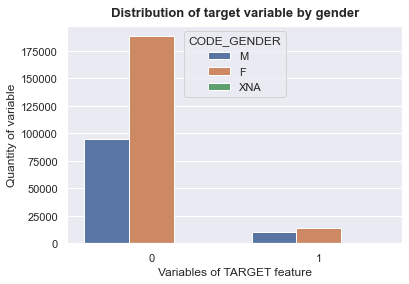

In [48]:
sns.countplot(data=application_train, x="TARGET", hue="CODE_GENDER")
plt.title("Distribution of target variable by gender", fontsize=13, fontweight="bold", pad=10)
plt.xlabel("Variables of TARGET feature")
plt.ylabel("Quantity of variable");

In [49]:
countF = len(application_train[(application_train["CODE_GENDER"] == "F") & (application_train["TARGET"] == 1)])
countM = len(application_train[(application_train["CODE_GENDER"] == "M") & (application_train["TARGET"] == 1)])

nobsF = application_train["CODE_GENDER"].value_counts()["F"]
nobsM = application_train["CODE_GENDER"].value_counts()["M"]

alfa = 0.05

p_value = prop.test_proportions_2indep(countF, nobsF, countM, nobsM, compare="ratio", return_results=False)[1]

print("The result is significant at p < 0.05:", p_value < alfa)

The result is significant at p < 0.05: True


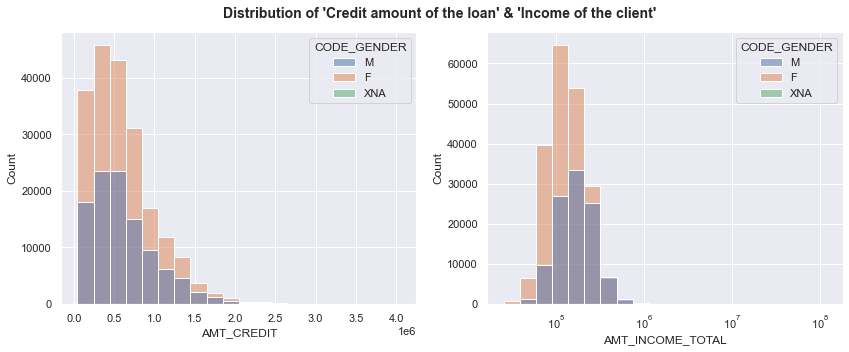

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.histplot(ax=axes[0], data=application_train, x="AMT_CREDIT", bins=20, hue="CODE_GENDER")
sns.histplot(ax=axes[1], data=application_train, x="AMT_INCOME_TOTAL", hue="CODE_GENDER", log_scale=True, bins=20)
fig.suptitle("Distribution of 'Credit amount of the loan' & 'Income of the client'", y=0.95, fontsize=14, fontweight="bold");

In [51]:
print("Average income of female client:", round(application_train.groupby("CODE_GENDER")["AMT_INCOME_TOTAL"].mean()["F"], 0))
print("Average income of male client:", round(application_train.groupby("CODE_GENDER")["AMT_INCOME_TOTAL"].mean()["M"], 0))

Average income of female client: 156032.0
Average income of male client: 193396.0


In [52]:
print("Average credit amount of female client:", round(application_train.groupby("CODE_GENDER")["AMT_CREDIT"].mean()["F"], 0))
print("Average credit amount of male client:", round(application_train.groupby("CODE_GENDER")["AMT_CREDIT"].mean()["M"], 0))

Average credit amount of female client: 592767.0
Average credit amount of male client: 611095.0


## Outliers - Days employed

In [53]:
application_train["DAYS_EMPLOYED"].describe()

count   307,511.00
mean     63,815.05
std     141,275.77
min     -17,912.00
25%      -2,760.00
50%      -1,213.00
75%        -289.00
max     365,243.00
Name: DAYS_EMPLOYED, dtype: float64

In [54]:
application_train[application_train["DAYS_EMPLOYED"] > 0]["NAME_INCOME_TYPE"].value_counts()

Pensioner     55352
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

After inspecting DAYS_EMPLOYED feature I have noticed that max value is unusually big. Then I have filtered NAME_INCOME_TYPE where DAYS_EMPLOYED > 0 and found out that it is Pensioner and Unemployed. So I have changed all values bigger than 0 to 0 and also converted negative numbers to positive. The majority of values were negative because they indicated how many days before the application the person started current employment.

In [55]:
application_train["DAYS_EMPLOYED"] = np.where((application_train["DAYS_EMPLOYED"] > 0), 0, application_train["DAYS_EMPLOYED"])
application_test["DAYS_EMPLOYED"] = np.where((application_test["DAYS_EMPLOYED"] > 0), 0, application_test["DAYS_EMPLOYED"])

application_train["DAYS_EMPLOYED"] = application_train["DAYS_EMPLOYED"] * -1
application_test["DAYS_EMPLOYED"] = application_test["DAYS_EMPLOYED"] * -1

In [56]:
application_train["DAYS_EMPLOYED"].describe()

count   307,511.00
mean      1,954.85
std       2,307.07
min           0.00
25%         289.00
50%       1,213.00
75%       2,760.00
max      17,912.00
Name: DAYS_EMPLOYED, dtype: float64

## Artificial features

### Contract status of previous application

We have dataset with information about previous applications, where also is information about contract status (approved, cancelled etc.). I have merged it with main dataset, because it is important to know client's history. Validation scores after this were a little better. 

In [252]:
previous_application_status = pd.get_dummies(previous_application[["SK_ID_CURR", "NAME_CONTRACT_STATUS"]], prefix="CONTRACT_STATUS").groupby("SK_ID_CURR").sum().reset_index()

application_train = pd.merge(application_train, previous_application_status, on="SK_ID_CURR", how="left").fillna(0)
application_test = pd.merge(application_test, previous_application_status, on="SK_ID_CURR", how="left").fillna(0)

### Payment status of previous installments

installments_payments dataset includes information about payments of every previous disbursed credits. I was able to conclude which payments were paid on time and which not, and these additional features had better impact to the validation score.

In [253]:
condlist = [installments_payments["DAYS_INSTALMENT"] - installments_payments["DAYS_ENTRY_PAYMENT"] == 0,
            installments_payments["DAYS_INSTALMENT"] - installments_payments["DAYS_ENTRY_PAYMENT"] < 0,
            installments_payments["DAYS_INSTALMENT"] - installments_payments["DAYS_ENTRY_PAYMENT"] > 0]

choicelist = ["In time", "Late", "In Advance"]

installments_payments["PAYMENT_STATUS"] = np.select(condlist, choicelist, None)

In [254]:
payments_status = pd.get_dummies(installments_payments[["SK_ID_CURR", "PAYMENT_STATUS"]], prefix="PAYMENT_STATUS").groupby("SK_ID_CURR").sum().reset_index()

application_train = pd.merge(application_train, payments_status, on="SK_ID_CURR", how="left").fillna(0)
application_test = pd.merge(application_test, payments_status, on="SK_ID_CURR", how="left").fillna(0)

### Loan-to-Value Ratio

The Loan-to-Value Ratio (LVR) is the amount the client is borrowing, represented as a percentage of the value of the property he is buying. The bigger your deposit, the lower the LVR will be. Some credits have LVR values which are bigger than 100 and in this case it means that insurance price is included in credit amount. I think that for this reason LVR ratio is somehow distorted but nevertheless the validation scores of all models are slightly better. I have tried to flag the insurance but the results were worse.  

In [255]:
application_train["LVR"] = application_train["AMT_CREDIT"] / application_train["AMT_GOODS_PRICE"] * 100
application_test["LVR"] = application_test["AMT_CREDIT"] / application_test["AMT_GOODS_PRICE"] * 100

### Prolonged credit

bureau dataset, where is information about previous credits provided by other financial institutions, has one column whether credit was prolonged and how many times. Firstly I have counted how many times one client had his credit(s) prolonged in total, but the scores were a little bit worse, and then I have tried just to flag if client had prolonged credit(s) in his history or not, and this time results were slightly better, but not much.

In [256]:
credit_prolonged = bureau.groupby("SK_ID_CURR")["CNT_CREDIT_PROLONG"].count().reset_index()

application_train = pd.merge(application_train, credit_prolonged, on="SK_ID_CURR", how="left").fillna(0)
application_test = pd.merge(application_test, credit_prolonged, on="SK_ID_CURR", how="left").fillna(0)

application_train["CNT_CREDIT_PROLONG"] = np.where((application_train["CNT_CREDIT_PROLONG"] > 0), 1, application_train["CNT_CREDIT_PROLONG"])
application_test["CNT_CREDIT_PROLONG"] = np.where((application_test["CNT_CREDIT_PROLONG"] > 0), 1, application_test["CNT_CREDIT_PROLONG"])

In [257]:
%%script false

for col in range(0,2):
    sns.kdeplot(application_train[application_train["TARGET"] == col]["DEF_60_CNT_SOCIAL_CIRCLE"], shade=True)

Couldn't find program: 'false'


### Future installments

From monthly balance snapshots of previous POS (point of sales) and cash loans dataset I have extracted most recent information about still active contracts and how much installments are left to pay.

In [258]:
future_instalments = (pos_cash_balance[(pos_cash_balance["MONTHS_BALANCE"] == -1) & (pos_cash_balance["NAME_CONTRACT_STATUS"] == "Active")]
                      .groupby("SK_ID_CURR")["CNT_INSTALMENT_FUTURE"]
                      .sum().reset_index())

application_train = pd.merge(application_train, future_instalments, on="SK_ID_CURR", how="left").fillna(0)
application_test = pd.merge(application_test, future_instalments, on="SK_ID_CURR", how="left").fillna(0)

### The latest balance of credit card

I have tried to calculate the average monthly difference of credit card balance and actual limit in my previous attempt, but the impact to validation score was worse, and this time I took just last month data and not all period - the result was slightly better except for Logistic regression and Stochastic gradient descent, but decrease for latters was very small, so I have decided to leave this articial feature.

In [259]:
credit_card_balance["BALANCE_DIFF"] = credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"] - credit_card_balance["AMT_BALANCE"]

In [260]:
credit_card_diff = (credit_card_balance[credit_card_balance["MONTHS_BALANCE"] == -1][["SK_ID_CURR", "BALANCE_DIFF"]]
                    .groupby("SK_ID_CURR")["BALANCE_DIFF"]
                    .mean()
                    .reset_index())

In [261]:
application_train = pd.merge(application_train, credit_card_diff, on="SK_ID_CURR", how="left").fillna(0)
application_test = pd.merge(application_test, credit_card_diff, on="SK_ID_CURR", how="left").fillna(0)

### Previous credits of all forms

Other datasets are consists of information about credits of various forms from Home Credit or other financial instution, and I have counted each of them for every client.

In [262]:
count_other_credits = bureau.groupby("SK_ID_CURR")["SK_ID_BUREAU"].nunique().reset_index().rename(columns={"SK_ID_BUREAU": "OTHER_CREDITS"})
count_pos_cash_balance = pos_cash_balance.groupby("SK_ID_CURR")["SK_ID_PREV"].nunique().reset_index().rename(columns={"SK_ID_PREV": "POS_CASH"})
count_credit_cards = credit_card_balance.groupby("SK_ID_CURR")["SK_ID_PREV"].nunique().reset_index().rename(columns={"SK_ID_PREV": "CREDIT_CARDS"})
count_previous_application = previous_application.groupby("SK_ID_CURR")["SK_ID_PREV"].nunique().reset_index().rename(columns={"SK_ID_PREV": "PREV_APPLICATIONS"})

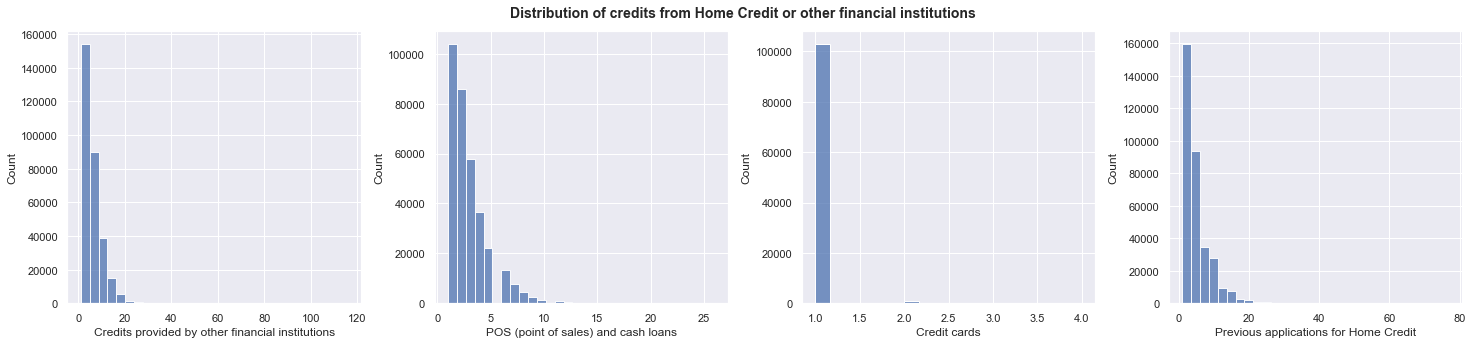

In [263]:
fig, axes = plt.subplots(ncols=4, figsize=(25,5))
sns.histplot(ax=axes[0], data=count_other_credits, x="OTHER_CREDITS", bins=30)
sns.histplot(ax=axes[1], data=count_pos_cash_balance, x="POS_CASH", bins=30)
sns.histplot(ax=axes[2], data=count_credit_cards, x="CREDIT_CARDS")
sns.histplot(ax=axes[3], data=count_previous_application, x="PREV_APPLICATIONS", bins=30)
fig.suptitle("Distribution of credits from Home Credit or other financial institutions", y=0.95, fontsize=14, fontweight="bold")
axes[0].set(xlabel="Credits provided by other financial institutions")
axes[1].set(xlabel="POS (point of sales) and cash loans")
axes[2].set(xlabel="Credit cards")
axes[3].set(xlabel="Previous applications for Home Credit")
plt.subplots_adjust(wspace=0.25);

In [264]:
history = [count_other_credits, count_pos_cash_balance, count_credit_cards, count_previous_application]

for dataset in history:
    application_train = pd.merge(application_train, dataset, on="SK_ID_CURR", how="left").fillna(0)
    application_test = pd.merge(application_test, dataset, on="SK_ID_CURR", how="left").fillna(0)

### Custom transformers

In [265]:
# Custom transformer for blending similar values in ORGANIZATION_TYPE feature.
get_organization_type = FunctionTransformer(blend_organization_type)

In [266]:
# Custom transformer for flagging DPD of credit crads.
get_credit_card_dpd = FunctionTransformer(credit_card_dpd, kw_args={"credit_card_df": credit_card_balance})

In [267]:
# Custom transformer for counting DPD from POS (point of sales) and cash loans.
get_pos_cash_dpd = FunctionTransformer(pos_cash_dpd, kw_args={"pos_cash_df": pos_cash_balance})

In [268]:
# Custom transformer for creating column with insurance flag.
get_flag_insurance = FunctionTransformer(flag_insurance)

Before binning the DAYS_BIRTH feature I have converted the values from days to years and visualized target distribution by age. In the graphs below we can see that the biggest difference is till 40 year and between 50 and 65 years. According to that I created bins for pandas cut function.

In [269]:
# Convert age by days to age by years.

application_train["AGE"] = application_train["DAYS_BIRTH"] / -365
application_test["AGE"] = application_test["DAYS_BIRTH"] / -365

application_train = application_train.drop(columns="DAYS_BIRTH")
application_test = application_test.drop(columns="DAYS_BIRTH")

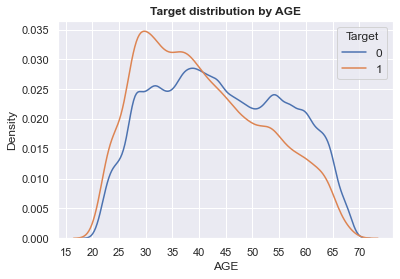

In [270]:
targets = [0, 1]

for target in targets:
    sns.kdeplot(data=application_train[application_train["TARGET"] == target], x="AGE", label=target)
    
plt.title("Target distribution by AGE", fontweight="bold")
plt.legend(prop={"size": 12}, title="Target")
plt.xticks(np.arange(15, 75, 5));

In [271]:
# Custom transformer for binning the AGE feature.
age_bins = [application_train["AGE"].min(), 27, 40, 50, 65, application_train["AGE"].max()]
age_labels = ["27_YEARS", "27-40_YEARS", "40-50_YEARS", "50-65_YEARS_MORE", "65_YEARS_MORE"]

get_age_binning = FunctionTransformer(pandas_binning, kw_args={"feature": "AGE", "bins": age_bins, "labels": age_labels})

In [272]:
# Custom transformer to count different types of credits in other financial institutions.

scarce_values = ["Mortgage", "Microloan", "Loan for business development", "Another type of loan", "Unknown type of loan", "Loan for working capital replenishment", "Cash loan (non-earmarked)",
                 "Real estate loan", "Loan for the purchase of equipment", "Loan for purchase of shares (margin lending)", "Mobile operator loan", "Interbank credit"]

get_bureau_credit_type_counter = FunctionTransformer(bureau_credit_type_counter, kw_args={"bureau_df": bureau, "scarce_values": scarce_values})

In [273]:
# Custom transformer to count different types of credits in previous applications of Home Credit.

get_prev_credit_type_counter = FunctionTransformer(prev_credit_type_counter, kw_args={"previous_application_df": previous_application})

In [274]:
# Custom transformer to count different types of credits in previous applications of Home Credit.

get_prev_flag_insurance = FunctionTransformer(prev_flag_insurance, kw_args={"previous_application_df": previous_application})

In [275]:
# Custom transformer for calculating ratio of loan annuity and income. 

get_annuity_income_ratio = FunctionTransformer(annuity_income_ratio)

In [276]:
# Custom transformer for calculating ratio of previous loans and current income.

get_prev_annuity_income_ratio = FunctionTransformer(prev_annuity_income_ratio, kw_args={"previous_application_df": previous_application})

In [277]:
# Custom transformer which sums up all columns with numbers of enquiries to Credit Bureau about the client.

enquiries_list = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", 
                  "AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]

get_enquiries = FunctionTransformer(enquiries, kw_args={"enquiries_list": enquiries_list})

In [278]:
# Custom transformer for flagging DPD during period of previous credits provided by other financial institutions.

dpd_notation = ["1", "2", "3", "4", "5"]

get_prev_dpd_flag = FunctionTransformer(prev_dpd_flag, kw_args={"bureau_balance_df": bureau_balance,
                                                                "bureau_df": bureau,
                                                                "dpd_notation": dpd_notation})

In [279]:
# Custom transformer for getting down payment rate of previous applications.

get_down_payment_rate = FunctionTransformer(down_payment_rate, kw_args={"previous_application_df": previous_application})

In [280]:
# Custom transformer for getting average number of version of installment calendar.

get_installments_version = FunctionTransformer(installments_version, kw_args={"installments_payments_df": installments_payments})

In [281]:
# Custom transformer for calculating ratio of client's total monthly debt and monthly income.

get_debt_income_ratio = FunctionTransformer(debt_income_ratio, kw_args={"bureau_df": bureau})

In [282]:
# Custom transformer for adding up values of columns about client social circles.

get_client_social_circle = FunctionTransformer(client_social_circle)

In [283]:
# Custom transformer which drops irrelevant SK_ID_CURR column in pipeline.

get_drop_id = FunctionTransformer(drop_id)

In [284]:
# Custom transformer for multiplying values of columns with ratings of the region where client lives.

get_region_rating = FunctionTransformer(region_rating)

In [285]:
# Custom transformer for adding up values of columns with score from external data source.

get_external_source = FunctionTransformer(external_source)

# Main models

In [286]:
# Data used for training, validation and prediction.

X = application_train.drop(columns=["TARGET"])
y = application_train["TARGET"]

X_test = application_test.copy()

SK_ID_CURR = application_test["SK_ID_CURR"]

In this case ordinary train/test splitting strategy is not suitable, because dataset is imbalanced and we should preserve correct proportion of target variables in both sets after splitting. scikit StratifiedShuffleSplit method should do the work.

In [287]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=42)

for train_index, val_index in splitter.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [288]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transformer", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

## Logistic Regression

In [289]:
log_reg = LogisticRegression(
    class_weight="balanced",
    random_state=42
    )

In [290]:
log_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_organization_type),
        ("custom_preprocessor_2", get_credit_card_dpd),
        ("custom_preprocessor_3", get_flag_insurance),
        ("custom_preprocessor_4", get_age_binning),
        ("custom_preprocessor_5", get_bureau_credit_type_counter),
        ("custom_preprocessor_6", get_prev_credit_type_counter),
        ("custom_preprocessor_7", get_prev_flag_insurance),
        ("custom_preprocessor_8", get_annuity_income_ratio),
        ("custom_preprocessor_9", get_prev_annuity_income_ratio),
        ("custom_preprocessor_10", get_installments_version),
        ("custom_preprocessor_11", get_drop_id),
        ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        ("model", log_reg)
    ]
)

In [291]:
log_pipe.fit(X_train, y_train)
log_probs = log_pipe.predict_proba(X_val)
log_score_rt = round(roc_auc_score(y_val, log_probs[:, 1]), 5)
print("Cross-validation score:", log_score_rt)

Cross-validation score: 0.75824


In [292]:
%%time

log_predictions = log_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, log_predictions, "log")

Wall time: 2.38 s


### ELI5

In [293]:
# Dataframe with all additional columns from custom transfomers used in LogisticRegression pipeline.

log_df = X_train.copy()

log_df = blend_organization_type(input_df=log_df)
log_df = credit_card_dpd(input_df=log_df, credit_card_df=credit_card_balance)
log_df = flag_insurance(input_df=log_df)
log_df = pandas_binning(input_df=log_df, feature="AGE", bins=age_bins, labels=age_labels)
log_df = bureau_credit_type_counter(input_df=log_df, bureau_df=bureau, scarce_values=scarce_values)
log_df = prev_credit_type_counter(input_df=log_df, previous_application_df=previous_application)
log_df = prev_flag_insurance(input_df=log_df, previous_application_df=previous_application)
log_df = annuity_income_ratio(input_df=log_df)
log_df = prev_annuity_income_ratio(input_df=log_df, previous_application_df=previous_application)
log_df = installments_version(input_df=log_df, installments_payments_df=installments_payments)
log_df = drop_id(input_df=log_df)

In [294]:
# Steps for getting names of features used in ELI5.

features_before_ohe = log_pipe.named_steps["preprocessor"].transformers_[0][2]
log_features = log_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = log_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = log_df.columns[remainder_features_indexes]
log_features.extend(remainder_features) 

In [295]:
eli5.explain_weights(log_pipe.named_steps["model"], top=10, feature_names=log_features)

Explanation(estimator="LogisticRegression(class_weight='balanced', random_state=42)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='AMT_CREDIT', weight=0.6354449776582114, std=None, value=None), FeatureWeight(feature='OBS_30_CNT_SOCIAL_CIRCLE', weight=0.26365202675899463, std=None, value=None), FeatureWeight(feature='FLAG_DOCUMENT_3', weight=0.24563171176388207, std=None, value=None)], neg=[FeatureWeight(feature='AMT_GOODS_PRICE', weight=-0.6823072655452586, std=None, value=None), FeatureWeight(feature='EXT_SOURCE_3', weight=-0.41751542202377273, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-0.39369067908129374, std=None, value=None), FeatureWeight(feature='EXT_SOURCE_2', weight=-0.39136647651586226, std=None, value=None), FeatureWeight(feature='OBS_60_CNT_SOCIAL_CIRCLE', weight=-0.25609024123646945, std=None, value=None), FeatureWeight(feature='FLAG_EMP_PHONE', weight=-0.22268072310639112, std=None, value=None), FeatureWeight(feature='POS_CASH', weight=-0.19503659387111758, std=None, value=None)], pos_remaining=97, neg_remaining=87), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Classification report

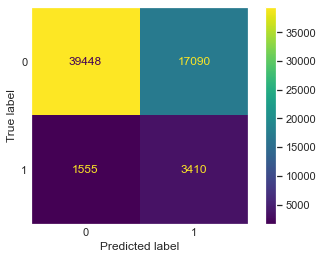

In [296]:
ConfusionMatrixDisplay.from_estimator(log_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [297]:
log_pred = log_pipe.predict(X_val)

print(classification_report(y_val, log_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



## Stochastic gradient descent

After hyperpamameteres tuning private leaderboard score increased from 0.73030 to 0.73775 and when slightly increased again after setting class_weight parameter.

In [298]:
tuned_params = {
    "loss": "modified_huber",
    "alpha": 0.00015,
    "max_iter": 500,
    "learning_rate": "constant",
}

In [299]:
sgd = SGDClassifier(loss=tuned_params["loss"],
                    alpha=tuned_params["alpha"],
                    max_iter=tuned_params["max_iter"],
                    learning_rate=tuned_params["learning_rate"],
                    random_state=42,
                    eta0=0.000001,
                    class_weight={0: 0.0807, 0: 0.9193})

In [300]:
sgd_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_organization_type),
        ("custom_preprocessor_2", get_credit_card_dpd),
        ("custom_preprocessor_3", get_flag_insurance),
        ("custom_preprocessor_4", get_age_binning),
        ("custom_preprocessor_5", get_prev_credit_type_counter),
        ("custom_preprocessor_6", get_prev_flag_insurance),
        ("custom_preprocessor_7", get_annuity_income_ratio),
        ("custom_preprocessor_8", get_prev_annuity_income_ratio),
        ("custom_preprocessor_9", get_enquiries),
        ("custom_preprocessor_10", get_prev_dpd_flag),
        ("custom_preprocessor_11", get_installments_version),
        ("custom_preprocessor_12", get_external_source),
        ("custom_preprocessor_13", get_drop_id),
        ("preprocessor", preprocessor),
        ("oversample", SMOTE(random_state=42, sampling_strategy=0.2)),
        ("undersample", RandomUnderSampler(random_state=42, sampling_strategy=0.3)),
        ("scaler", StandardScaler()),
        ("model", sgd)
    ]
)



In [301]:
sgd_pipe.fit(X_train, y_train)
sgd_probs = sgd_pipe.predict_proba(X_val)
sgd_score_rt = round(roc_auc_score(y_val, sgd_probs[:, 1]), 5)
print("Cross-validation score:", sgd_score_rt)

Cross-validation score: 0.75667


In [302]:
%%time

sgd_predictions = sgd_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, sgd_predictions, "sgd")

Wall time: 4.29 s


### ELI5

In [303]:
# Dataframe with all additional columns from custom transfomers used in SGDClassifier pipeline.

sgd_df = X_train.copy()

sgd_df = blend_organization_type(input_df=sgd_df)
sgd_df = credit_card_dpd(input_df=sgd_df, credit_card_df=credit_card_balance)
sgd_df = flag_insurance(input_df=sgd_df)
sgd_df = pandas_binning(input_df=sgd_df, feature="AGE", bins=age_bins, labels=age_labels)
sgd_df = prev_credit_type_counter(input_df=sgd_df, previous_application_df=previous_application)
sgd_df = prev_flag_insurance(input_df=sgd_df, previous_application_df=previous_application)
sgd_df = annuity_income_ratio(input_df=sgd_df)
sgd_df = prev_annuity_income_ratio(input_df=sgd_df, previous_application_df=previous_application)
sgd_df = enquiries(input_df=sgd_df, enquiries_list=enquiries_list)
sgd_df = prev_dpd_flag(input_df=sgd_df, bureau_balance_df=bureau_balance, bureau_df=bureau, dpd_notation=dpd_notation)
sgd_df = installments_version(input_df=sgd_df, installments_payments_df=installments_payments)
sgd_df = external_source(input_df=sgd_df)
sgd_df = drop_id(input_df=sgd_df)

In [304]:
# Steps for getting names of features used in ELI5.

features_before_ohe = sgd_pipe.named_steps["preprocessor"].transformers_[0][2]
sgd_features = sgd_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = sgd_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = sgd_df.columns[remainder_features_indexes]
sgd_features.extend(remainder_features) 

In [305]:
eli5.explain_weights(sgd_pipe.named_steps["model"], top=10, feature_names=sgd_features)

Explanation(estimator="SGDClassifier(alpha=0.00015, class_weight={0: 0.9193}, eta0=1e-06,\n              learning_rate='constant', loss='modified_huber', max_iter=500,\n              random_state=42)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='LVR', weight=0.05896772021226326, std=None, value=None), FeatureWeight(feature='PAYMENT_STATUS_Late', weight=0.05039663901001451, std=None, value=None), FeatureWeight(feature='CONTRACT_STATUS_Refused', weight=0.049558252602369436, std=None, value=None), FeatureWeight(feature='CNT_INSTALMENT_FUTURE', weight=0.042431804386699676, std=None, value=None), FeatureWeight(feature='ANNUITY_VS_INCOME', weight=0.034462886256290674, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.5201364874311758, std=None, value=None), FeatureWeight(feature='EXT_SOURCE', weight=-0.2272926584730432, std=None, value=None), FeatureWeight(feature='DAYS_EMPLOYED', weight=-0.04950720582877759, std=None, value=None), FeatureWeight(feature='FLAG_OWN_CAR_Y', weight=-0.04344156820390155, std=None, value=None), FeatureWeight(feature='CNT_CREDIT_PROLONG', weight=-0.04078920119444011, std=None, value=None)], pos_remaining=86, neg_remaining=94), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Classification report

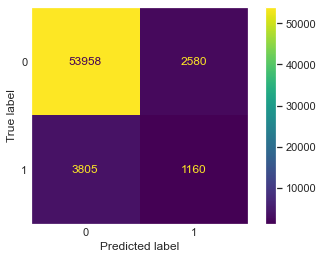

In [306]:
ConfusionMatrixDisplay.from_estimator(sgd_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [307]:
sgd_pred = sgd_pipe.predict(X_val)

print(classification_report(y_val, sgd_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     56538
           1       0.31      0.23      0.27      4965

    accuracy                           0.90     61503
   macro avg       0.62      0.59      0.61     61503
weighted avg       0.88      0.90      0.89     61503



## Random forest

Hyperparameters tuning of Random forest had the biggest impact for final score of all models. The privare leaderboard score inscreased from 0.71094 to 0.74325. The attempt to balance the class didn't have positive impact.

In [308]:
tuned_params = {
    "n_estimators": 1200,
    "criterion": "entropy",
    "max_features": "sqrt",
    "max_depth": 17,
}

In [309]:
forest = RandomForestClassifier(random_state=42,
                                n_estimators=tuned_params["n_estimators"],
                                criterion=tuned_params["criterion"],
                                max_features=tuned_params["max_features"],
                                max_depth=tuned_params["max_depth"])

In [391]:
forest_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_region_rating),
        ("custom_preprocessor_2", get_drop_id),
        ("preprocessor", preprocessor),
        ("oversample", SMOTE(random_state=42, sampling_strategy=0.2)),
        ("undersample", RandomUnderSampler(random_state=42, sampling_strategy=1)),
        ("model", forest)
    ]
)

In [392]:
forest_pipe.fit(X_train, y_train)
forest_probs = forest_pipe.predict_proba(X_val)
forest_score_rt = round(roc_auc_score(y_val, forest_probs[:, 1]), 5)
print("Cross-validation score:", forest_score_rt)

Cross-validation score: 0.7523


In [393]:
%%time

forest_predictions = forest_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, forest_predictions, "forest")

Wall time: 776 ms


### ELI5

In [117]:
# Dataframe with all additional columns from custom transfomers used in RandomForestClassifier pipeline.

forest_df = X_train.copy()

forest_df = region_rating(input_df=forest_df)
forest_df = drop_id(input_df=forest_df)

In [118]:
# Steps for getting names of features used in ELI5.

features_before_ohe = forest_pipe.named_steps["preprocessor"].transformers_[0][2]
forest_features = forest_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = forest_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = forest_df.columns[remainder_features_indexes]
forest_features.extend(remainder_features) 

In [119]:
eli5.explain_weights(forest_pipe.named_steps["model"], top=10, feature_names=forest_features)

Weight,Feature
0.0859 ± 0.0319,EXT_SOURCE_2
0.0796 ± 0.0266,EXT_SOURCE_3
0.0384 ± 0.0131,AGE
0.0333 ± 0.0100,DAYS_EMPLOYED
0.0318 ± 0.0065,DAYS_ID_PUBLISH
0.0308 ± 0.0083,DAYS_LAST_PHONE_CHANGE
0.0303 ± 0.0055,DAYS_REGISTRATION
0.0293 ± 0.0058,AMT_ANNUITY
0.0292 ± 0.0089,LVR
0.0279 ± 0.0066,AMT_CREDIT


### Classification report

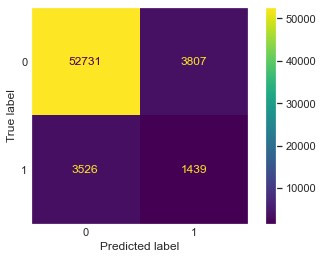

In [394]:
ConfusionMatrixDisplay.from_estimator(forest_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [395]:
forest_pred = forest_pipe.predict(X_val)

print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     56538
           1       0.27      0.29      0.28      4965

    accuracy                           0.88     61503
   macro avg       0.61      0.61      0.61     61503
weighted avg       0.88      0.88      0.88     61503



## XGBoost classifier

After hyperparameters tuning the Kaggle score was even lower so I have left default parameters and just changed scale_pos_weight which controls the balance of positive and negative weights.

In [327]:
xgboost = XGBClassifier(seed=42,
                        use_label_encoder=False,
                        eval_metric="auc",
                        scale_pos_weight=0.92)

In [375]:
xgboost_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_prev_credit_type_counter),
        ("custom_preprocessor_2", get_region_rating),
        ("custom_preprocessor_3", get_drop_id),
        ("preprocessor", preprocessor),
        ("model", xgboost)
    ]
)

In [376]:
xgboost_pipe.fit(X_train, y_train)
xgboost_probs = xgboost_pipe.predict_proba(X_val)
xgboost_score_rt = round(roc_auc_score(y_val, xgboost_probs[:, 1]), 5)
print("Cross-validation score:", xgboost_score_rt)

Cross-validation score: 0.7614


In [377]:
%%time

xgboost_predictions = xgboost_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, xgboost_predictions, "xgboost")

Wall time: 725 ms


### ELI5

In [126]:
# Dataframe with all additional columns from custom transfomers used in XGBClassifier pipeline.

xgboost_df = X_train.copy()

xgboost_df = prev_credit_type_counter(input_df=xgboost_df, previous_application_df=previous_application)
xgboost_df = region_rating(input_df=xgboost_df)
xgboost_df = drop_id(input_df=xgboost_df)

In [127]:
# Steps for getting names of features used in ELI5.

features_before_ohe = xgboost_pipe.named_steps["preprocessor"].transformers_[0][2]
xgboost_features = xgboost_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = xgboost_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = xgboost_df.columns[remainder_features_indexes]
xgboost_features.extend(remainder_features) 

In [128]:
eli5.explain_weights(xgboost_pipe.named_steps["model"], top=10, feature_names=xgboost_features)

Weight,Feature
0.0248,EXT_SOURCE_2
0.0245,CNT_CREDIT_PROLONG
0.0225,NAME_EDUCATION_TYPE_Higher education
0.0223,EXT_SOURCE_3
0.0194,CODE_GENDER_M
0.0184,CODE_GENDER_F
0.0144,POS_CASH
0.0143,NAME_INCOME_TYPE_Working
0.0131,FLAG_OWN_CAR_Y
0.0124,NAME_EDUCATION_TYPE_Secondary / secondary special


### Classification report

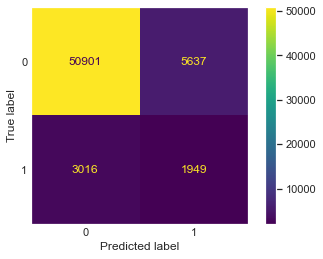

In [378]:
ConfusionMatrixDisplay.from_estimator(xgboost_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [374]:
xgb_pred = xgboost_pipe.predict(X_val)

print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56538
           1       0.43      0.10      0.16      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.54      0.56     61503
weighted avg       0.89      0.92      0.89     61503



## AdaBoost classifier

In [396]:
tuned_params = {
    "n_estimators": 250,
    "learning_rate": 0.8
}

In [397]:
ada = AdaBoostClassifier(random_state=42,
                         n_estimators=tuned_params["n_estimators"],
                         learning_rate=tuned_params["learning_rate"])

In [403]:
ada_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_pos_cash_dpd),
        ("custom_preprocessor_2", get_prev_credit_type_counter),
        ("custom_preprocessor_3", get_annuity_income_ratio),
        ("custom_preprocessor_4", get_installments_version),
        ("custom_preprocessor_5", get_client_social_circle),
        ("custom_preprocessor_6", get_drop_id),
        ("preprocessor", preprocessor),
        ("model", ada)
    ]
)

In [404]:
ada_pipe.fit(X_train, y_train)
ada_probs = ada_pipe.predict_proba(X_val)
ada_score_rt = round(roc_auc_score(y_val, ada_probs[:, 1]), 5)
print("Cross-validation score:", ada_score_rt)

Cross-validation score: 0.7623


In [405]:
%%time

ada_predictions = ada_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, ada_predictions, "ada")

Wall time: 4.62 s


### ELI5

In [136]:
# Dataframe with all additional columns from custom transfomers used in SGDClassifier pipeline.

ada_df = X_train.copy()

ada_df = pos_cash_dpd(input_df=ada_df, pos_cash_df=pos_cash_balance)
ada_df = prev_credit_type_counter(input_df=ada_df, previous_application_df=previous_application)
ada_df = annuity_income_ratio(input_df=ada_df)
ada_df = installments_version(input_df=ada_df, installments_payments_df=installments_payments)
ada_df = client_social_circle(input_df=ada_df)
ada_df = drop_id(input_df=ada_df)

In [137]:
# Steps for getting names of features used in ELI5.

features_before_ohe = ada_pipe.named_steps["preprocessor"].transformers_[0][2]
ada_features = ada_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = ada_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = ada_df.columns[remainder_features_indexes]
ada_features.extend(remainder_features) 

In [138]:
eli5.explain_weights(ada_pipe.named_steps["model"], top=10, feature_names=ada_features)

Weight,Feature
0.1080 ± 0.6208,EXT_SOURCE_2
0.0800 ± 0.5426,EXT_SOURCE_3
0.0640 ± 0.4895,AGE
0.0480 ± 0.4275,AMT_GOODS_PRICE
0.0400 ± 0.3919,AMT_CREDIT
0.0360 ± 0.3726,CNT_INSTALMENT_FUTURE
0.0320 ± 0.3520,BALANCE_DIFF
0.0280 ± 0.3299,AMT_ANNUITY
0.0280 ± 0.3299,DAYS_EMPLOYED
0.0240 ± 0.3061,LVR


### Classification report

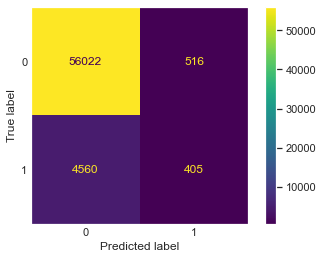

In [406]:
ConfusionMatrixDisplay.from_estimator(ada_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [402]:
ada_pred = ada_pipe.predict(X_val)

print(classification_report(y_val, ada_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     56538
           1       0.25      0.40      0.31      4965

    accuracy                           0.85     61503
   macro avg       0.60      0.65      0.61     61503
weighted avg       0.89      0.85      0.87     61503



## LightGBM classifier

In [407]:
tuned_params = {
    "learning_rate": 0.08,
    "n_estimators": 175,
    "objective": "binary",
    "scale_pos_weight": 0.92,
    "reg_alpha": 0.4,
    "reg_lambda": 0.2,
    "random_state": 42
    }

In [408]:
lgbm = LGBMClassifier(
    learning_rate=tuned_params["learning_rate"],
    n_estimators=tuned_params["n_estimators"],
    objective=tuned_params["objective"],
    scale_pos_weight=tuned_params["scale_pos_weight"],
    reg_alpha=tuned_params["reg_alpha"],
    reg_lambda=tuned_params["reg_lambda"],
    random_state=tuned_params["random_state"]
    )

In [418]:
lgbm_pipe = Pipeline(
    steps=[
        ("custom_preprocessor_1", get_credit_card_dpd),
        ("custom_preprocessor_2", get_bureau_credit_type_counter),
        ("custom_preprocessor_3", get_prev_flag_insurance),
        ("custom_preprocessor_4", get_prev_annuity_income_ratio),
        ("custom_preprocessor_5", get_installments_version),
        ("custom_preprocessor_6", get_region_rating),
        ("custom_preprocessor_7", get_drop_id),
        ("preprocessor", preprocessor),
        ("model", lgbm)
    ]
)

In [419]:
lgbm_pipe.fit(X_train, y_train)
lgbm_probs = lgbm_pipe.predict_proba(X_val)
lgbm_score_rt = round(roc_auc_score(y_val, lgbm_probs[:, 1]), 5)
print("Cross-validation score:", lgbm_score_rt)

Cross-validation score: 0.77195


In [420]:
%%time

lgbm_predictions = lgbm_pipe.predict_proba(X_test)
    
export_predictions(SK_ID_CURR, lgbm_predictions, "lgbm")

Wall time: 1.99 s


### ELI5

In [146]:
# Dataframe with all additional columns from custom transfomers used in SGDClassifier pipeline.

lgbm_df = X_train.copy()

lgbm_df = credit_card_dpd(input_df=lgbm_df, credit_card_df=credit_card_balance)
lgbm_df = bureau_credit_type_counter(input_df=lgbm_df, bureau_df=bureau, scarce_values=scarce_values)
lgbm_df = prev_flag_insurance(input_df=lgbm_df, previous_application_df=previous_application)
lgbm_df = prev_annuity_income_ratio(input_df=lgbm_df, previous_application_df=previous_application)
lgbm_df = installments_version(input_df=lgbm_df, installments_payments_df=installments_payments)
lgbm_df = region_rating(input_df=lgbm_df)
lgbm_df = drop_id(input_df=lgbm_df)

In [147]:
# Steps for getting names of features used in ELI5.

features_before_ohe = lgbm_pipe.named_steps["preprocessor"].transformers_[0][2]
lgbm_features = lgbm_pipe.named_steps["preprocessor"].named_transformers_["cat_transformer"].get_feature_names_out(features_before_ohe).tolist()
remainder_features_indexes = lgbm_pipe.named_steps["preprocessor"].transformers_[1][2]
remainder_features = lgbm_df.columns[remainder_features_indexes]
lgbm_features.extend(remainder_features) 

In [148]:
eli5.explain_weights(lgbm_pipe.named_steps["model"], top=10, feature_names=lgbm_features)

Weight,Feature
0.2124,EXT_SOURCE_2
0.1878,EXT_SOURCE_3
0.0387,LVR
0.0382,AGE
0.0328,PAYMENT_STATUS_Late
0.0259,BALANCE_DIFF
0.0240,DAYS_EMPLOYED
0.0235,PAYMENT_STATUS_In Advance
0.0230,CONTRACT_STATUS_Refused
0.0222,AMT_GOODS_PRICE


### Classification report

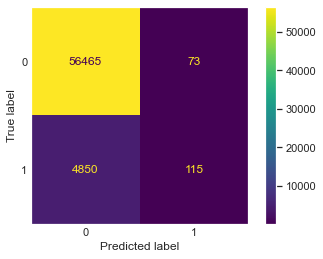

In [421]:
ConfusionMatrixDisplay.from_estimator(lgbm_pipe, X_val, y_val)
plt.tick_params(axis=u"both", which=u"both", length=0)
plt.grid(b=None);

In [422]:
lgbm_pred = lgbm_pipe.predict(X_val)

print(classification_report(y_val, lgbm_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.61      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.77      0.51      0.50     61503
weighted avg       0.90      0.92      0.88     61503



# Averaged predictions

In [152]:
stacked_predictions = np.column_stack(
    (
        #log_predictions[:, 1],
        #sgd_predictions[:, 1],
        forest_predictions[:, 1],
        ada_predictions[:, 1],
        xgboost_predictions[:, 1],
        lgbm_predictions[:, 1]
        )
    )

averaged_predictions = stacked_predictions.mean(1).reshape(48744,)

output = pd.DataFrame({"SK_ID_CURR": application_test["SK_ID_CURR"], "TARGET": averaged_predictions})
output.to_csv("submissions/averaged_predictions.csv", index=False)

# Results

In [153]:
pd.set_option("display.float_format","{:,.5f}".format)

log_base_score = 0.6234
sgd_base_score = 0.52481
forest_base_score = 0.70868
xgboost_base_score = 0.74728
ada_base_score = 0.7396
lgbm_base_score = None
avg_base_score = None

log_score = 0.75924
sgd_score = 0.75778	
forest_score = 0.76120
xgboost_score = 0.76517
ada_score = 0.76547
lgbm_score = 0.76955
avg_score = None

kaggle_base_log_score = 0.61468
kaggle_base_sgd_score = 0.52776
kaggle_base_forest_score = 0.69674
kaggle_base_xgboost_score = 0.72467
kaggle_base_ada_score = 0.75643
kaggle_base_lgbm_score = 0.75643
kaggle_base_avg_score = 0.69156

kaggle_log_score = 0.74351
kaggle_sgd_score = 0.73926
kaggle_forest_score = 0.74325
kaggle_xgboost_score = 0.74671
kaggle_ada_score = 0.74992
kaggle_lgbm_score = 0.75725
kaggle_avg_score = 0.75550

scores_table = pd.DataFrame({"Base Score": [log_base_score, sgd_base_score, forest_base_score, xgboost_base_score,
                                            ada_base_score, lgbm_base_score, avg_base_score],
                             "Score": [log_score, sgd_score, forest_score, xgboost_score, ada_score, lgbm_score, avg_score],
                             "Kaggle Base Score": [kaggle_base_log_score, kaggle_base_sgd_score, kaggle_base_forest_score, 
                                                   kaggle_base_xgboost_score, kaggle_base_ada_score, kaggle_base_lgbm_score, kaggle_base_avg_score],
                             "Kaggle Score": [kaggle_log_score, kaggle_sgd_score, kaggle_forest_score, kaggle_xgboost_score,
                                              kaggle_ada_score, kaggle_lgbm_score, kaggle_avg_score],
                             "Real-Time Score": [log_score_rt, sgd_score_rt, forest_score_rt, xgboost_score_rt, ada_score_rt, lgbm_score_rt, None],
                             "Better/Worse": [log_score_rt - log_score, sgd_score_rt - sgd_score, forest_score_rt - forest_score, 
                                              xgboost_score_rt - xgboost_score, ada_score_rt - ada_score, lgbm_score_rt - lgbm_score, None]
                             }
                            ).set_axis( 
                                 ["Logistic Regression", "Stochastic gradient descent", "Random forest",
                                  "XGBoost", "AdaBoost", "LGBM", "Averaged classifiers"], axis="index"
                                 )
                             
scores_table

,Base Score,Score,Kaggle Base Score,Kaggle Score,Real-Time Score,Better/Worse
Logistic Regression,0.62340,0.75924,0.61468,0.74351,0.75926,0.00002
Stochastic gradient descent,0.52481,0.75778,0.52776,0.73775,0.75812,0.00034
Random forest,0.70868,0.76120,0.69674,0.74325,0.76149,0.00029
XGBoost,0.74728,0.76517,0.72467,0.74671,0.76321,-0.00196
AdaBoost,0.73960,0.76547,0.75643,0.74992,0.76792,0.00245
LGBM,NaN,0.76955,0.75643,0.75725,0.77149,0.00194
Averaged classifiers,NaN,NaN,0.69156,0.75550,NaN,NaN


# Attempts

In [154]:
%%script false
# Client type (information from previous applications).

client_type = previous_application[["SK_ID_CURR", "NAME_CLIENT_TYPE"]].groupby("SK_ID_CURR").apply(lambda x: mode(x)[0][0][1]).reset_index().rename(columns={0: "CLIENT_TYPE"})

Couldn't find program: 'false'


In [155]:
%%script false
# Average monthly difference between credit card's balance and actual limit.  

credit_card_difference = credit_card_balance[["SK_ID_CURR", "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"]]
credit_card_difference["CREDIT_LIMIT_DIFF"] = credit_card_difference["AMT_BALANCE"] - credit_card_difference["AMT_CREDIT_LIMIT_ACTUAL"]

avg_credit_card_difference = credit_card_difference.groupby("SK_ID_CURR")["CREDIT_LIMIT_DIFF"].mean().reset_index()

Couldn't find program: 'false'


In [156]:
%%script false
# How many days the credit was overdue.

credit_day_overdue = bureau[(bureau["CREDIT_DAY_OVERDUE"] > 0)].groupby("SK_ID_CURR")["CREDIT_DAY_OVERDUE"].sum().reset_index()

Couldn't find program: 'false'


In [157]:
%%script false

datasets = [application_train, application_test]
documents = [3, 6, 8]

for dataset in datasets:
    dataset["FLAG_DOCUMENTS"] = 0

    for i in documents:
        dataset["FLAG_DOCUMENTS"] += dataset[f"FLAG_DOCUMENT_{i}"]
        
    for n in range(2,22):
        dataset.drop(columns=[f"FLAG_DOCUMENT_{n}"], inplace=True)

Couldn't find program: 'false'
